In [1]:
# Environment
import gym
import sys

In [2]:
# Models and computation
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
# torch.set_default_tensor_type("torch.cuda.FloatTensor")

In [3]:
# Visualization
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import base64

In [4]:
# IO
from pathlib import Path
import time

In [5]:
if 'highway_env' not in sys.modules:
    try:
        import highway_env
    except ImportError:
        sys.path.append(r'..')
        import highway_env
else:
    print("You've got it!")

In [6]:
# ==================================
#        Main script
# ==================================

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 113      |
|    ep_rew_mean     | 0.497    |
| time/              |          |
|    fps             | 111      |
|    iterations      | 1        |
|    time_elapsed    | 18       |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 138          |
|    ep_rew_mean          | 0.548        |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 2            |
|    time_elapsed         | 37           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0059434557 |
|    clip_fraction        | 0.0374       |
|    clip_range           | 0.2          |
|    en

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 192          |
|    ep_rew_mean          | 0.681        |
| time/                   |              |
|    fps                  | 109          |
|    iterations           | 11           |
|    time_elapsed         | 206          |
|    total_timesteps      | 22528        |
| train/                  |              |
|    approx_kl            | 0.0045316424 |
|    clip_fraction        | 0.0376       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.85        |
|    explained_variance   | 0.132        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.000909    |
|    n_updates            | 100          |
|    policy_gradient_loss | -0.00186     |
|    std                  | 1            |
|    value_loss           | 0.0154       |
------------------------------------------
------------------------------------------
| rollout/ 

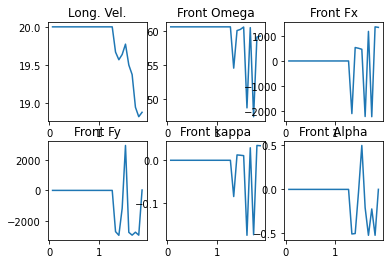

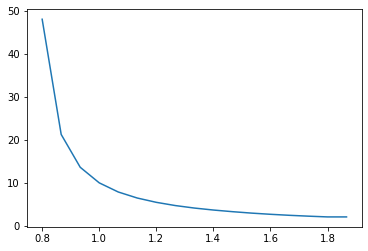

In [9]:
if __name__ == "__main__":
    env = highway_env.envs.collision_env.CollisionEnv()

    # Recommended Environment Hypertuning Parameters:
    # env.configure({
    #     "duration": 10,  # [s]
    #     "road_friction": 1.0,
    #     "stopping_vehicles_count": 5,
    #     "time_to_intervene": 2, # [s]
    #     "time_after_collision": 0, # [s]
    #     "vehicles_density": 2,
    #     "vehicles_count": 20,
    # })

    # Uncomment to check environment with OpenAi Gym:
    # check_env(env)

    # Uncomment to try training an PPO algorithm on this environemt:
    model = PPO("MlpPolicy", env, learning_rate=0.0003, n_steps=2048,
                batch_size=64, n_epochs=10,verbose=1)
    model.learn(total_timesteps=25000, )
    model.save("ppo_collision")
    model.load("ppo_collision")

    obs = env.reset()
    env.render()
    times = []
    model_params = []
    rewards = []
    velocity = []
    forces = []
    slips = []
    ttc = []
    done = False
    while not done:
        # Use just hard braking (will probably lock the wheel):
        action = np.array([-1, 0.0])

        # Uncomment to use RL algorithm actions:
        action, _states = model.predict(obs)

        obs, rew, done, info = env.step(action)
        times.append(info["time"])
        velocity.append(info["speed"])
        forces.append(info["tire_forces"])
        slips.append(info["slip_values"])
        ttc.append(info["ttc"])
        rewards.append(rew)
        
    env.close()
    velocity = np.vstack(velocity)
    forces = np.vstack(forces)
    slips = np.vstack(slips)
    
    plt.figure()
    plt.subplot(231)
    plt.plot(times, velocity[:,0])
    plt.title('Long. Vel.')
    plt.subplot(232)
    plt.plot(times, velocity[:,2])
    plt.title('Front Omega')
    plt.subplot(233)
    plt.plot(times, forces[:,0])
    plt.title('Front Fx')
    plt.subplot(234)
    plt.plot(times, forces[:,1])
    plt.title('Front Fy')
    plt.subplot(235)
    plt.plot(times, slips[:,0])
    plt.title('Front kappa')
    plt.subplot(236)
    plt.plot(times, slips[:,1])
    plt.title('Front Alpha')
    plt.figure()
    plt.plot(times, ttc)
    plt.show()